In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [2]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [3]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [4]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431
3,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,0.520,0.535,0.534,0.522
...,...,...,...,...,...,...,...,...,...,...,...
469,8482089,Jake Neighbours,Neighbours,L,STL,77,L,0.439,0.393,0.405,0.445
470,8476468,J.T. Miller,Miller,C,VAN,94,L,0.528,0.517,0.496,0.523
471,8475842,Sam Carrick,Carrick,C,"ANA,EDM",77,R,0.435,0.397,0.423,0.451
472,8481618,Alex Newhook,Newhook,C,MTL,55,L,0.440,0.425,0.414,0.431


In [5]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [6]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [7]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,88,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
469,8481553,Bobby Brink,Brink,R,PHI,57,2,0,0
470,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,3,1,1
471,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,0,0,1
472,8478400,Colin White,White,C,"PIT,MTL",28,0,0,0


In [8]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [9]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [10]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [11]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [12]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)

In [13]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,27.94,15.13,3.99,13.76,36.97,9.56,20.85,23.91,399.0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,20.48,18.28,13.76,13.76,55.67,16.02,17.12,32.21,355.0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,https://assets.nhle.com/logos/nhl/svg/WSH_dark...,12.82,8.61,7.25,11.55,80.78,7.93,12.18,38.35,320.0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,https://assets.nhle.com/logos/nhl/svg/TOR_dark...,72.90,67.65,59.56,78.36,13.34,63.60,75.63,47.10,267.0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,https://assets.nhle.com/logos/nhl/svg/NSH_dark...,70.38,78.26,76.16,70.80,55.67,77.21,70.59,66.61,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8482089,Jake Neighbours,Neighbours,L,STL,77,L,43.9,39.3,40.5,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,15.13,4.20,5.25,17.75,80.78,4.72,16.44,38.66,317.0
472,8476468,J.T. Miller,Miller,C,VAN,94,L,52.8,51.7,49.6,...,https://assets.nhle.com/logos/nhl/svg/VAN_dark...,76.79,66.70,50.63,71.64,98.53,58.67,74.22,79.28,59.0
473,8475842,Sam Carrick,Carrick,C,ANA,77,R,43.5,39.7,42.3,...,https://assets.nhle.com/logos/nhl/svg/ANA_dark...,13.55,4.62,11.97,20.27,13.34,8.30,16.91,12.90,454.0
474,8481618,Alex Newhook,Newhook,C,MTL,55,L,44.0,42.5,41.4,...,https://assets.nhle.com/logos/nhl/svg/MTL_dark...,16.18,11.24,8.09,11.55,55.67,9.66,13.86,29.32,369.0


In [14]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,476.000000,476.000000,476.000000,476.000000
mean,49.243277,49.294328,49.371849,49.277731
std,4.980063,5.367198,5.360664,4.852625
min,33.100000,34.000000,34.700000,34.400000
50%,49.550000,49.650000,49.600000,49.600000
75%,52.600000,53.025000,53.200000,52.600000
80%,53.100000,53.900000,54.100000,53.100000
90%,54.850000,55.900000,56.000000,54.850000
max,62.700000,62.700000,63.900000,61.500000


In [15]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,476.000000,476.000000,476.000000
mean,2.302521,0.334034,0.462185
std,2.442793,0.704704,0.873371
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,13.000000,4.000000,6.000000


In [16]:
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= 55) or (row['satPercentageTied'] >= 55) or (row['usatPercentageClose'] >= 55) or (row['usatPercentageTied'] >= 55) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [17]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    394
1     82
Name: count, dtype: int64

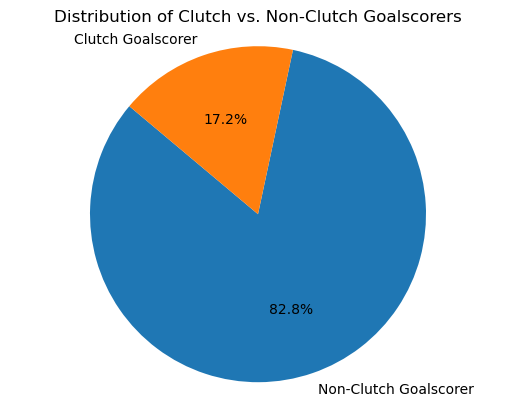

In [18]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [19]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_model.fit(train[x_var], train[y_var])

test['xgb_clutch_type'] = xgb_model.predict(test[x_var])
test['xgb_correct'] = (test['xgb_clutch_type'] == test['clutch_performance'])
xgb_accuracy = test['xgb_correct'].mean()
xgb_accuracy

0.993006993006993

In [119]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

metrics = {name: {'precision': [], 'recall': [], 'auc_pr': [], 'f1_score': []} for model_name in models}
def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    skf = StratifiedKFold(n_splits = 5)

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold

        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
            

        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }


for model_name, model in models.items():
    results = evaluate_model(model, x, y)
    for metric in metrics[model_name]:
        metrics[model_name][metric] = results[metric]

data_for_tests = {
    'precision': [metrics[name]['precision'] for name in models],
    'recall': [metrics[name]['recall'] for name in models],
    'auc_pr': [metrics[name]['auc_pr'] for name in models],
    'f1_score': [metrics[name]['f1_score'] for name in models],
}

for metric, data in data_for_tests.items():
    stat, p = friedmanchisquare(*data)
    print(f'Friedman test for {metric.capitalize()}: statistic={stat}, p-value={p}')''

SyntaxError: incomplete input (1777348547.py, line 1)

In [73]:
'''for model_name in metrics.keys():
    print(f"{model_name} recall: {metrics[model_name]['recall']}")'''
    

KNN recall: [1.0, 0.75, 1.0, 0.875, 0.8888888888888888, 0.7777777777777778, 1.0, 0.875, 0.75, 0.625]
Random Forest recall: [1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625]
XGBoost recall: [1.0, 0.875, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 0.875, 0.625]


In [82]:
'''import pandas as pd

# Extract precision scores
precision_data = []

for model_name, metrics_values in metrics.items():
    precision_scores = metrics_values['recall']
    
    for fold_index, score in enumerate(precision_scores):
        precision_data.append({
            'Model': model_name,
            'Fold': fold_index + 1,
            'Precision': score
        })

precision_df = pd.DataFrame(precision_data)

knn_precision = precision_df.loc[precision_df['Model'] == 'KNN', 'Precision'].values
random_forest_precision = precision_df.loc[precision_df['Model'] == 'Random Forest', 'Precision'].values
xgboost_forest_precision = precision_df.loc[precision_df['Model'] == 'XGBoost', 'Precision'].values

res = friedmanchisquare(knn_precision, random_forest_precision, xgboost_forest_precision)
print(res.statistic)
print(res.pvalue)

precision_df['Rank'] = precision_df.groupby('Fold')['Precision'].rank(ascending=False)

rank_sum = precision_df.groupby('Model')['Rank'].sum().reset_index()
rank_sum.columns = ['Model', 'Rank_Sum']
rank_sum['Sum Squared'] = rank_sum['Rank_Sum'] ** 2

chi_square = 12 / (10 * 3 * (3 + 1)) * rank_sum['Sum Squared'].sum() - 3 * 10 * (3 + 1)

print(chi_square)
'''

11.200000000000017
0.0036978637164828986
5.6000000000000085


Friedman test for Precision: statistic=0.15384615384614508, p-value=0.92596107864232
Friedman test for Recall: statistic=12.0909090909091, p-value=0.002368603956091912

Metrics Summary for Recall (p < 0.05):
                    mean
KNN            0.828889
Random Forest  0.946667
XGBoost        0.922222
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.080127  0.131853
Random Forest  0.080127       1.000000  0.685165
XGBoost        0.131853       0.685165  1.000000
Friedman test for Auc_pr: statistic=12.079999999999997, p-value=0.0023815589136168746

Metrics Summary for Auc_pr (p < 0.05):
                    mean
KNN            0.957873
Random Forest  0.996561
XGBoost        0.988016
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.026200  0.245688
Random Forest  0.026200       1.000000  0.246125
XGBoost        0.245688       0.246125  1.000000
Friedman test for F1_score: statistic=7.78571428571427, p-value=0.02038701413451

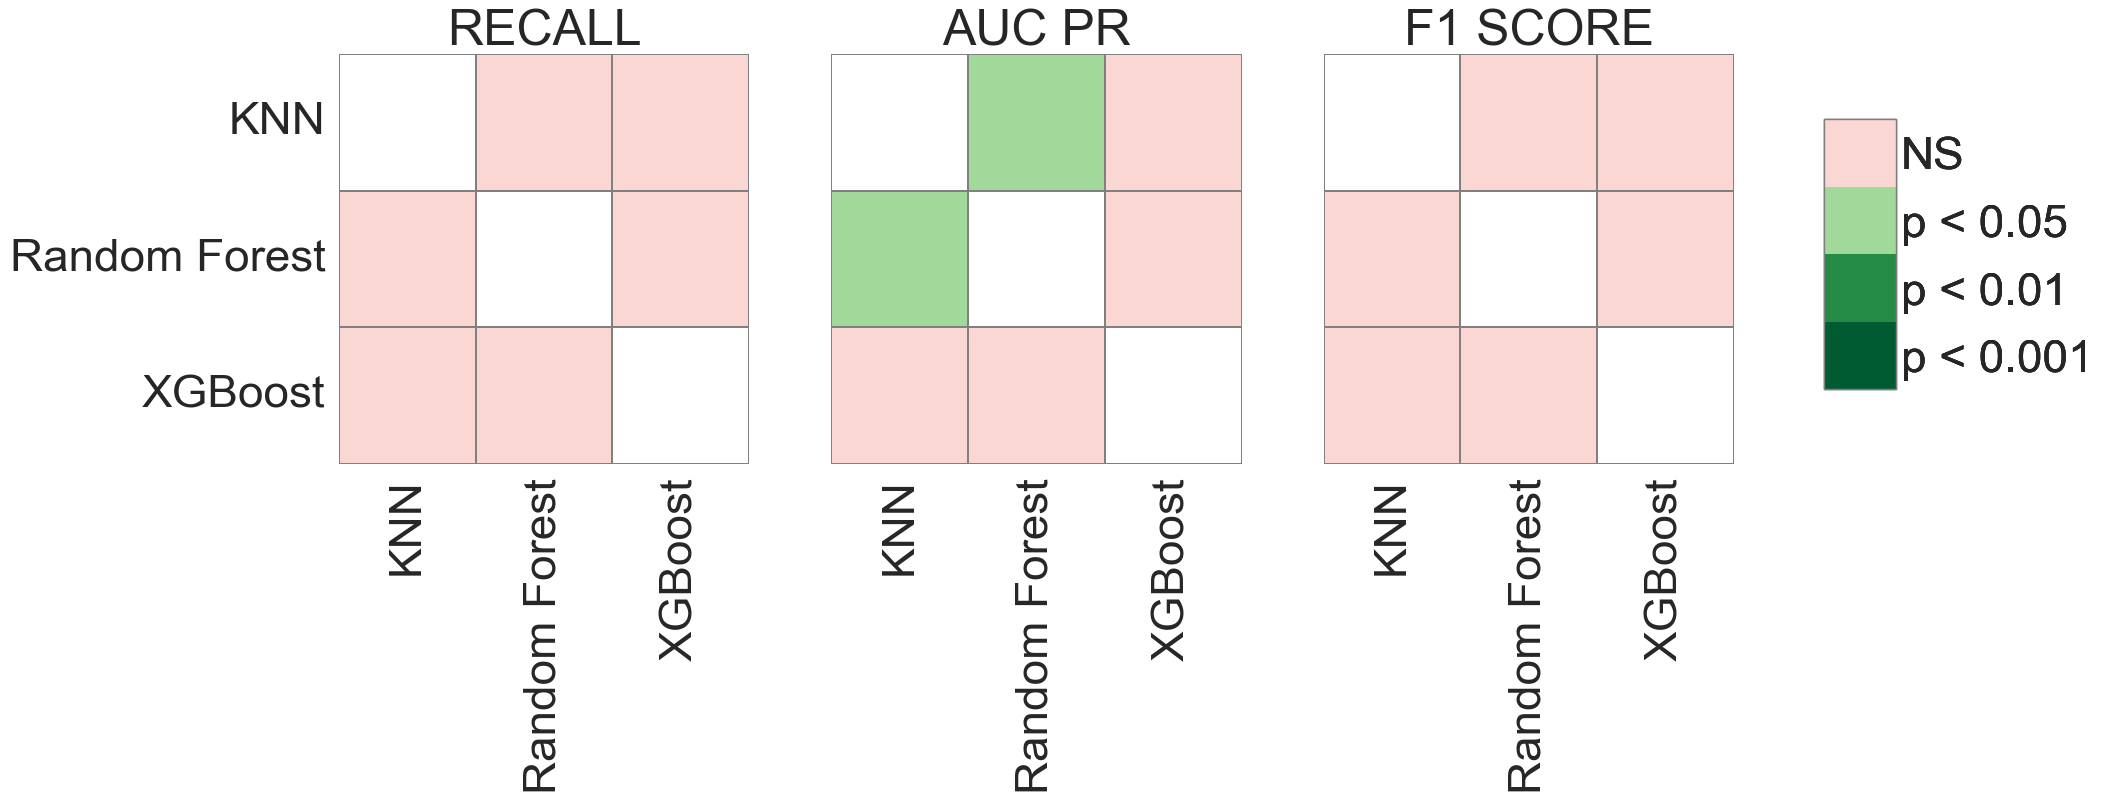

In [37]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp


x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

metrics_combined =  {'precision': [], 
     'recall': [], 
     'auc_pr': [], 
     'f1_score': []}

skf = StratifiedKFold(n_splits = 15)

def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold
    
        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
                
    
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    results = {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }
               
    return results
    
for model_name, model in models.items():
    scores = evaluate_model(model, x, y)
    for metric in scores:
        metrics_combined[metric].append(scores[metric])

sns.set(rc={'figure.figsize': (18, 9)}, font_scale = 3)
figure, axes = plt.subplots(1, 3, sharex = True, sharey= True)

i = 0

for name in metrics_combined:
    stat, p = friedmanchisquare(*metrics_combined[name])
    print(f'Friedman test for {name.capitalize()}: statistic={stat}, p-value={p}')
    
    if p < 0.05:
        df_scores = pd.DataFrame(metrics_combined[name]).T
        df_scores.columns = models.keys() 

        metrics_summary = df_scores.agg(['mean']).T
        print(f'\nMetrics Summary for {name.capitalize()} (p < 0.05):\n', metrics_summary)

        
        df_long = df_scores.melt(var_name='Model', value_name='Score')
        
        df = sp.posthoc_conover(df_long, group_col='Model', val_col='Score', p_adjust='holm')
        print(df)

        similarity_matrix = pd.DataFrame(df, index = models.keys())

        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'square': True}

        sub_ax, sub_c = sp.sign_plot(df, **heatmap_args, ax=axes[i])
        sub_ax.set_title(name.replace("_", " ").upper())
        i += 1
        if i >= 3:
            break

plt.show()


In [133]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=7)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=7)

evalset = [(train_x[x_var], train_y), (val_x[x_var], val_y)]

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x[x_var], train_y, eval_set=evalset)

[0]	validation_0-logloss:0.28742	validation_1-logloss:0.30238
[1]	validation_0-logloss:0.21077	validation_1-logloss:0.23646
[2]	validation_0-logloss:0.15858	validation_1-logloss:0.18568
[3]	validation_0-logloss:0.12000	validation_1-logloss:0.15091
[4]	validation_0-logloss:0.09328	validation_1-logloss:0.12770
[5]	validation_0-logloss:0.07361	validation_1-logloss:0.11220
[6]	validation_0-logloss:0.06005	validation_1-logloss:0.10432
[7]	validation_0-logloss:0.04856	validation_1-logloss:0.09839
[8]	validation_0-logloss:0.04110	validation_1-logloss:0.09677
[9]	validation_0-logloss:0.03522	validation_1-logloss:0.09357
[10]	validation_0-logloss:0.03119	validation_1-logloss:0.09080
[11]	validation_0-logloss:0.02732	validation_1-logloss:0.09161
[12]	validation_0-logloss:0.02377	validation_1-logloss:0.09086
[13]	validation_0-logloss:0.02162	validation_1-logloss:0.08937
[14]	validation_0-logloss:0.01959	validation_1-logloss:0.08732
[15]	validation_0-logloss:0.01773	validation_1-logloss:0.08830
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [135]:
y_true = val_y 
y_pred = xgb_model.predict(val_x[x_var])
y_pred_prob = xgb_model.predict_proba(val_x[x_var])[:, 1]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 0.97
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
AUC PR: 0.97


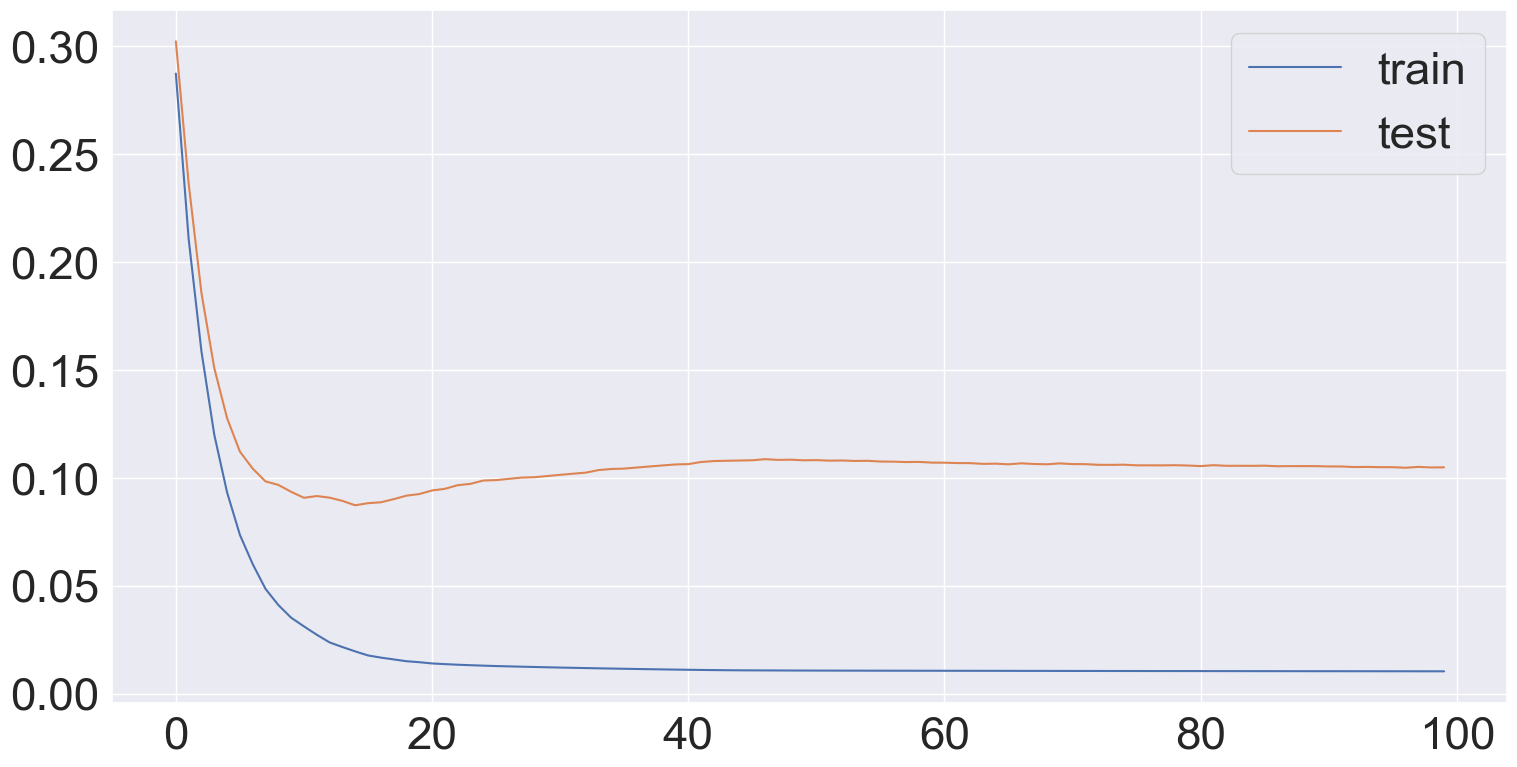

In [137]:
from matplotlib import pyplot

results = xgb_model.evals_result()
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

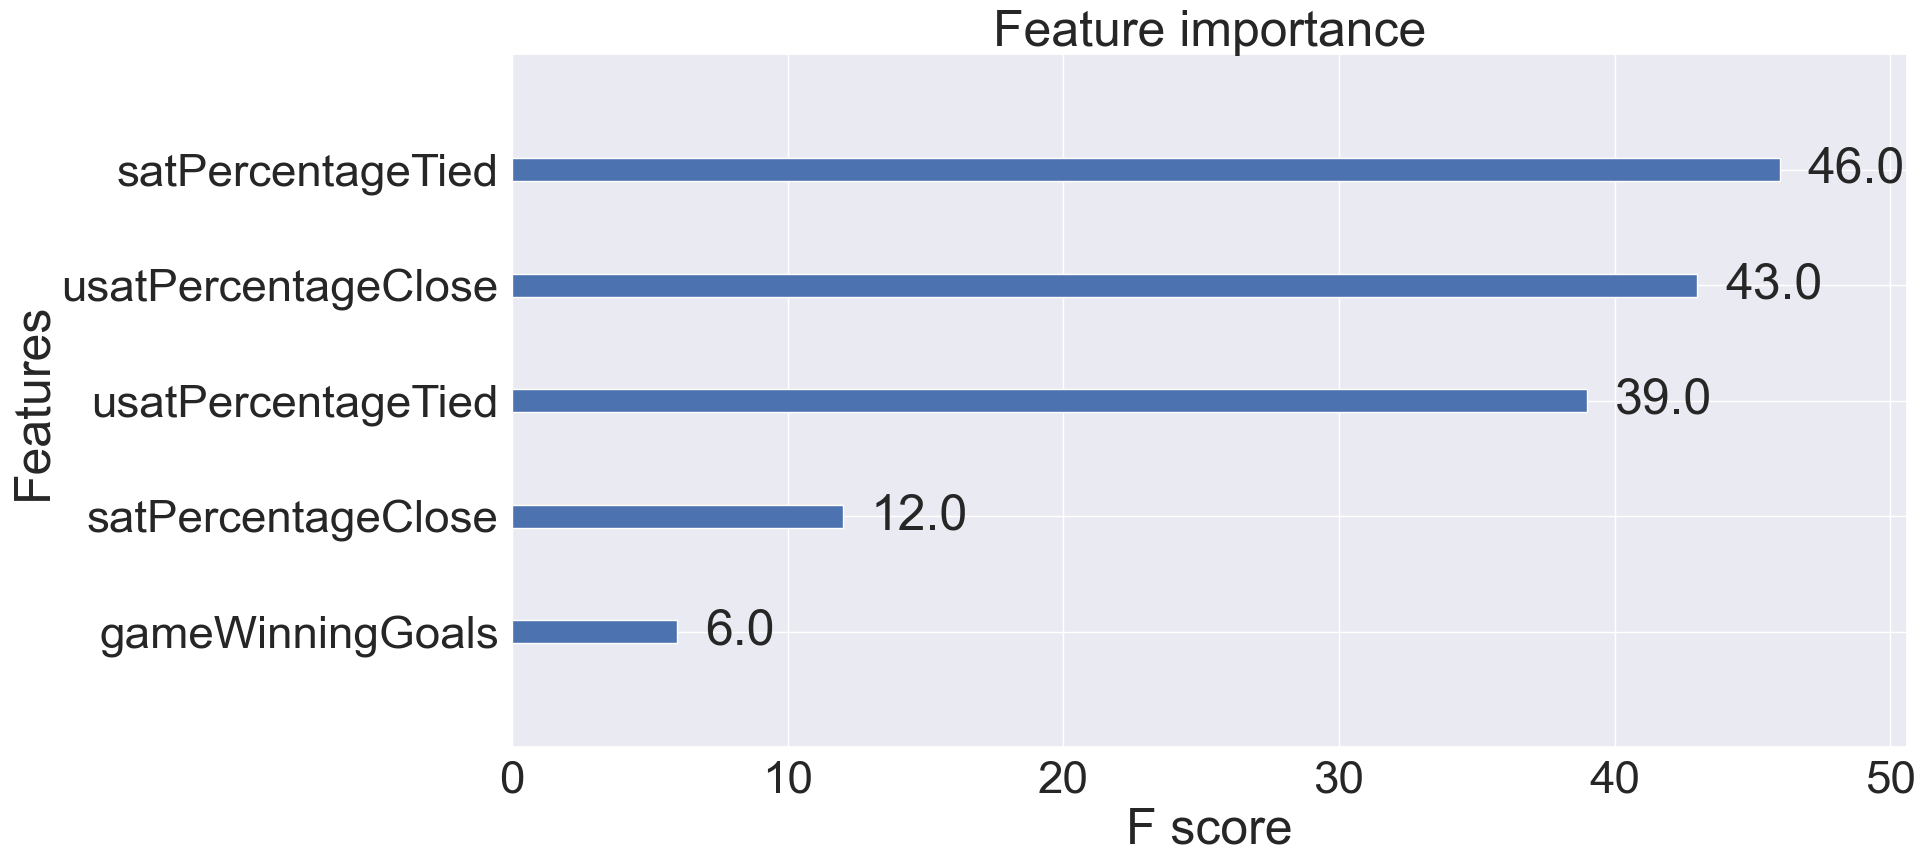

In [139]:
plot_importance(xgb_model)
pyplot.show()

In [141]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied', 'satPercentageClose']
y_var = 'clutch_performance'

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

evalset = [(train_x[x_var_adjusted], train_y), (val_x[x_var_adjusted], val_y)]

xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', early_stopping_rounds=15)
xgb_model_adjusted.fit(train_x[x_var_adjusted], train_y, eval_set=evalset)

[0]	validation_0-logloss:0.31340	validation_1-logloss:0.30984
[1]	validation_0-logloss:0.23098	validation_1-logloss:0.23584
[2]	validation_0-logloss:0.17607	validation_1-logloss:0.18966
[3]	validation_0-logloss:0.13867	validation_1-logloss:0.15907
[4]	validation_0-logloss:0.10814	validation_1-logloss:0.12784
[5]	validation_0-logloss:0.08678	validation_1-logloss:0.11463
[6]	validation_0-logloss:0.07084	validation_1-logloss:0.09830
[7]	validation_0-logloss:0.05947	validation_1-logloss:0.09418
[8]	validation_0-logloss:0.05095	validation_1-logloss:0.08672
[9]	validation_0-logloss:0.04437	validation_1-logloss:0.08158
[10]	validation_0-logloss:0.03926	validation_1-logloss:0.07722
[11]	validation_0-logloss:0.03473	validation_1-logloss:0.07921
[12]	validation_0-logloss:0.03163	validation_1-logloss:0.07463
[13]	validation_0-logloss:0.02877	validation_1-logloss:0.07459
[14]	validation_0-logloss:0.02668	validation_1-logloss:0.07255
[15]	validation_0-logloss:0.02467	validation_1-logloss:0.07420
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [143]:
from skopt import BayesSearchCV
import xgboost as xgb
import time

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200, 300, 400],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8] 
}

cv = StratifiedKFold(n_splits=10)

random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter= 20, n_jobs=-1)

evalset = [(train_x[x_var_adjusted], train_y), (val_x[x_var_adjusted], val_y)]

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset)
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print("Time: ", xgb_duration)


[0]	validation_0-logloss:0.38157	validation_1-logloss:0.40917
[1]	validation_0-logloss:0.24445	validation_1-logloss:0.27473
[2]	validation_0-logloss:0.18651	validation_1-logloss:0.21491
[3]	validation_0-logloss:0.15830	validation_1-logloss:0.19190
[4]	validation_0-logloss:0.12458	validation_1-logloss:0.15489
[5]	validation_0-logloss:0.11030	validation_1-logloss:0.12469
[6]	validation_0-logloss:0.09909	validation_1-logloss:0.11470
[7]	validation_0-logloss:0.09008	validation_1-logloss:0.10696
[8]	validation_0-logloss:0.08873	validation_1-logloss:0.10078
[9]	validation_0-logloss:0.07657	validation_1-logloss:0.08788
[10]	validation_0-logloss:0.07619	validation_1-logloss:0.08764
[11]	validation_0-logloss:0.07040	validation_1-logloss:0.08263
[12]	validation_0-logloss:0.06500	validation_1-logloss:0.07698
[13]	validation_0-logloss:0.06085	validation_1-logloss:0.07358
[14]	validation_0-logloss:0.05849	validation_1-logloss:0.07201
[15]	validation_0-logloss:0.05800	validation_1-logloss:0.06105
[1

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

xgb_best_model = random_search.best_estimator_

y_true = test_y 

y_pred = xgb_best_model.predict(test_x[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_x[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))


Accuracy: 0.99
Precision: 0.91
Recall: 1.0
F1 Score: 0.95
AUC PR: 1.0


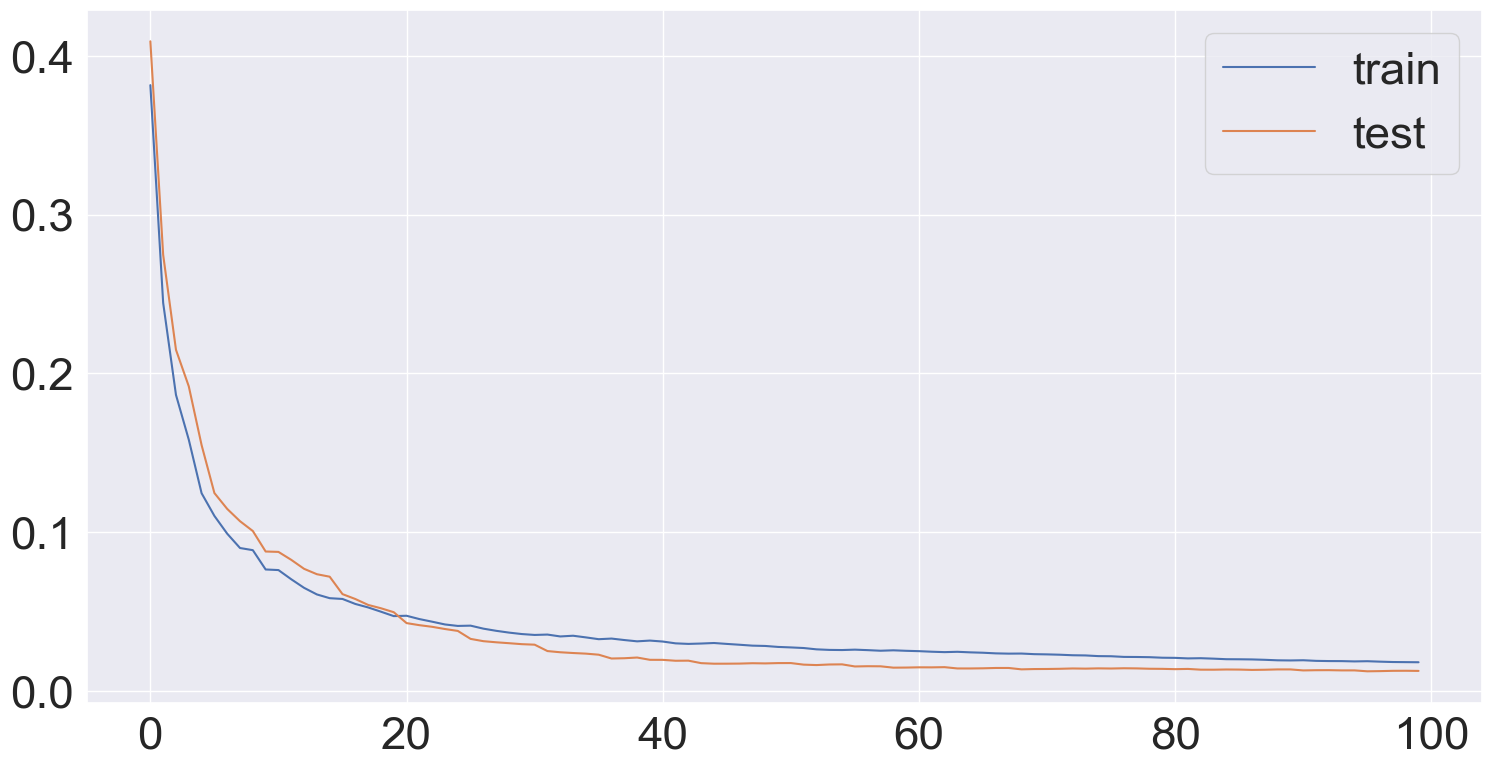

In [147]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

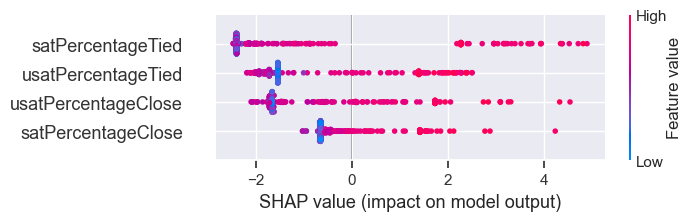

In [67]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_xgb[x_var_adjusted])

shap.summary_plot(shap_values, train_xgb[x_var_adjusted])

In [71]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], train_xgb[x_var_adjusted].iloc[0])

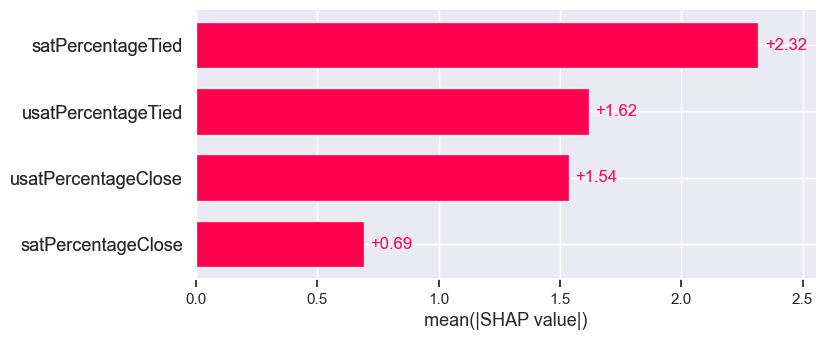

In [73]:
shap.plots.bar(shap_values)

In [102]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

train_xgb, test_xgb = train_test_split(random_sample, test_size=0.2, random_state=42)

evalset = [(train_xgb[x_var_adjusted], train_xgb[y_var]), (test_xgb[x_var_adjusted], test_xgb[y_var])]

xgb_best_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset, verbose=True)

y_pred_final = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob_final = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]

[0]	validation_0-logloss:0.56224	validation_1-logloss:0.56961
[1]	validation_0-logloss:0.50006	validation_1-logloss:0.50637
[2]	validation_0-logloss:0.44693	validation_1-logloss:0.45241
[3]	validation_0-logloss:0.40412	validation_1-logloss:0.41778
[4]	validation_0-logloss:0.36397	validation_1-logloss:0.37638
[5]	validation_0-logloss:0.32892	validation_1-logloss:0.34022
[6]	validation_0-logloss:0.29815	validation_1-logloss:0.30847
[7]	validation_0-logloss:0.27102	validation_1-logloss:0.28047
[8]	validation_0-logloss:0.24892	validation_1-logloss:0.26310
[9]	validation_0-logloss:0.22739	validation_1-logloss:0.24049
[10]	validation_0-logloss:0.20823	validation_1-logloss:0.22035
[11]	validation_0-logloss:0.19113	validation_1-logloss:0.20236
[12]	validation_0-logloss:0.17583	validation_1-logloss:0.18625
[13]	validation_0-logloss:0.16210	validation_1-logloss:0.17179
[14]	validation_0-logloss:0.14977	validation_1-logloss:0.15879
[15]	validation_0-logloss:0.13868	validation_1-logloss:0.14708
[1

In [103]:
y_true = test_xgb[y_var]
y_pred = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


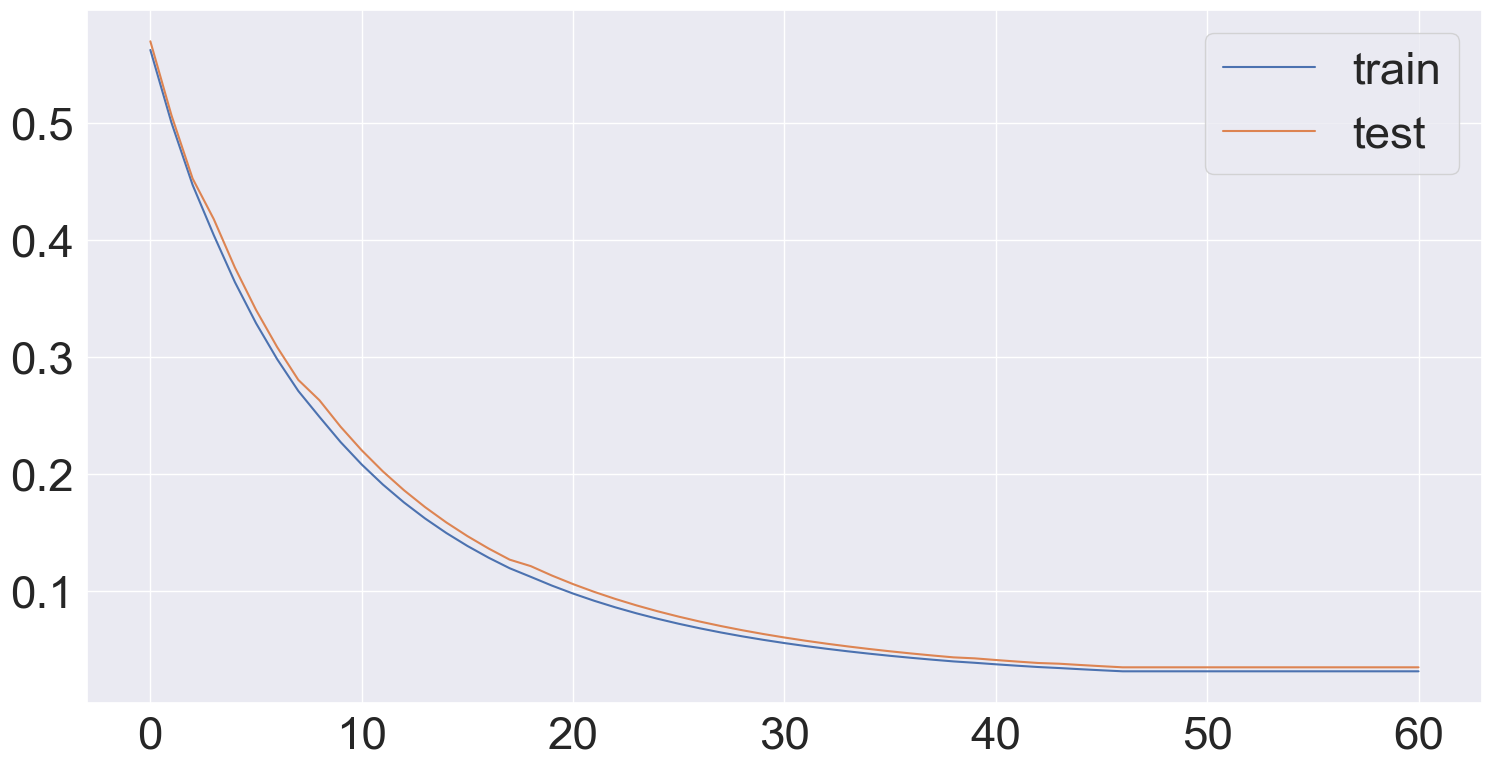

In [104]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# Step 1: Use the best model to make predictions on the test set
y_true = df_test['clutch_performance']  # True labels from the test set
y_pred = xgb_best_model.predict(df_test[x_var_adjusted])  # Make predictions

# Step 2: Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, xgb_best_model.predict_proba(df_test[x_var_adjusted])[:, 1])  # AUC-PR

# Step 3: Print the results
print("Test Set Metrics:")
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


In [33]:
xgb_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var])

y_train_pred = xgb_model.predict(train_xgb[x_var_adjusted])

y_test_pred = xgb_model.predict(test_xgb[x_var_adjusted])

train_accuracy = accuracy_score(train_xgb[y_var], y_train_pred)
train_precision = precision_score(train_xgb[y_var], y_train_pred)
train_recall = recall_score(train_xgb[y_var], y_train_pred)
train_f1 = f1_score(train_xgb[y_var], y_train_pred)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")


Training Set Metrics:
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


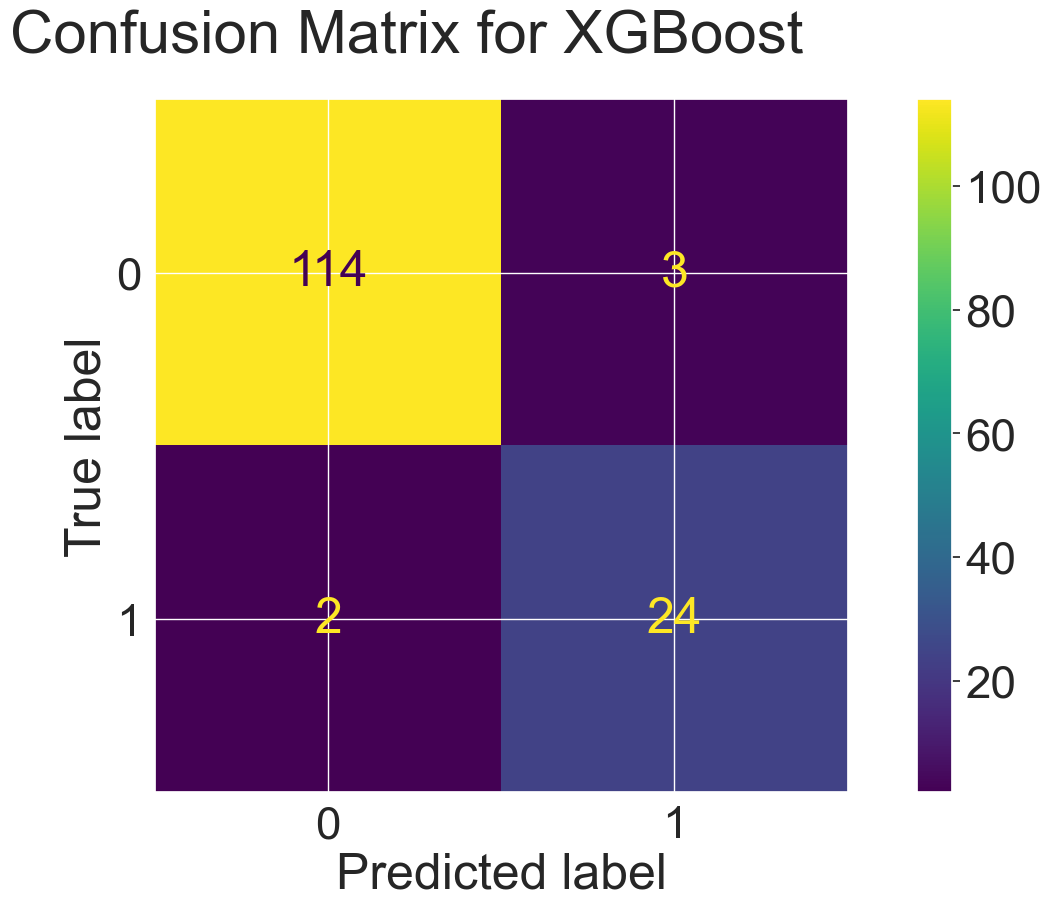

In [160]:
conf_matrix = confusion_matrix(y_pred_xgb, y_true_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [156]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(train[x_var], train[y_var].values.ravel())

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda':[0.1, 0.5, 1.0]
    
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_jobs = -1,n_iter=100)

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var])
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print ("Time: ", xgb_duration)

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


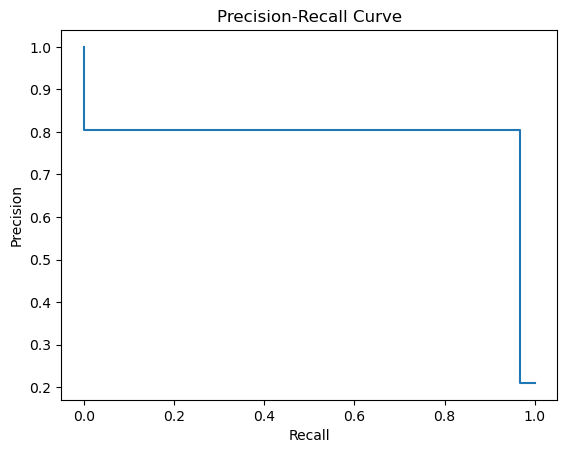

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

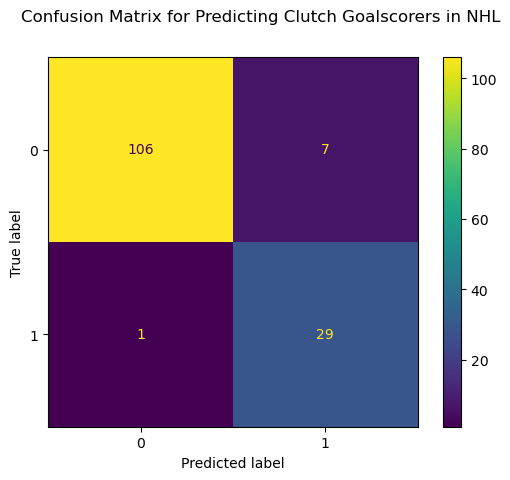

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
